# Odhad CDPF

## Cíl analýzy

Cílem analýzy je odhad neoklasické agrengátní CDPF.

## Data a metoda

Pro odhad byly použity následující hodnoty:

- hrubá přidaná hodnota (Gross Value Added) (převedená na stálé ceny roku 2010 pomocí deflátoru HDP),
- čistý fixní nefinanční kapitál (převedený na stálé ceny roku 2010 pomocí deflátoru kapitálových zásob),
- celkový počet odpracovaných hodin.

In [1]:
import eurostat
import pandas as pd
import statsmodels.api as sm
import numpy
from scipy.stats.mstats import gmean
import seaborn
import matplotlib.pyplot as plt

LOCATIONS = ["AT", "BE", "BG", "CZ", "DE", "DK", "ES", "FI", "FR", "HU", "IT", "NL", "PL", "PT", "RO", "SK", "SI", "SW"]
BASE_LOCATION = "FR"
START_YEAR = 1995
END_YEAR = 2019

### Hrubá přidaná hodnota (Gross Value Added)

Hrubá přidaná hodnota je načtena na základě kódu `nama_10_a10`.

In [5]:
data_1_es = eurostat.get_data_df('nama_10_a10')

In [162]:
data_1 = data_1_es
# Value added, gross
data_1 = data_1[data_1["na_item"].isin(["B1G", "D1"])]
# Total, all NACE activities
data_1 = data_1[data_1["nace_r2"] == "TOTAL"]
# Current prices, million euro
data_1 = data_1[data_1["unit"].isin(["CP_MEUR", "CP_MNAC", "PD10_NAC", "PD10_EUR"])]
data_1 = pd.melt(data_1, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                     value_name="value", var_name="year")
data_1 = data_1.pivot(index=["geo\\time", "year"], columns=["unit", "na_item"], values="value")
data_1 = pd.DataFrame(data_1)

data_1 = data_1.dropna()
# data_1[("CP_MNAC", "B1G")] = (data_1[("CP_MNAC", "B1G")] / data_1[("PD10_NAC", "B1G")]) / 100
data_1[("CP_MNAC", "D1")] = (data_1[("CP_MNAC", "D1")] / data_1[("PD10_NAC", "B1G")]) / 100
# data_1[("CP_MEUR", "B1G")] = (data_1[("CP_MEUR", "B1G")] / data_1[("PD10_EUR", "B1G")]) / 100
data_1[("CP_MEUR", "D1")] = (data_1[("CP_MEUR", "D1")] / data_1[("PD10_EUR", "B1G")]) / 100
data_1.columns = ['_'.join(col) for col in data_1.columns.values]
data_1 = data_1.rename({"CP_MNAC_B1G": "gross_value_added",
                        "CP_MEUR_B1G":  "gross_value_added_eur",
                        "CP_MNAC_D1": "compensation_of_employees",
                        "CP_MEUR_D1": "compensation_of_employees_eur",
                        "PD10_NAC_B1G": "implicit_deflator_2010",
                        "PD10_EUR_B1G": "implicit_deflator_2010_eur"
                        }, axis=1)
data_1["gross_value_added_eur_2010"] = (data_1["gross_value_added_eur"] / data_1["implicit_deflator_2010_eur"]) / 100
data_1["gross_value_added_2010"] = (data_1["gross_value_added"] / data_1["implicit_deflator_2010"]) / 100
data_1["compensation_of_employees_eur_2010"] = (data_1["gross_value_added_eur"] / data_1["implicit_deflator_2010_eur"]) / 100
data_1["compensation_of_employees_2010"] = (data_1["gross_value_added"] / data_1["implicit_deflator_2010"]) / 100
data_1 = data_1.reset_index()
data_1

,geo\time,year,gross_value_added_eur,compensation_of_employees_eur,gross_value_added,compensation_of_employees,implicit_deflator_2010_eur,implicit_deflator_2010,gross_value_added_eur_2010,gross_value_added_2010,compensation_of_employees_eur_2010,compensation_of_employees_2010
0,AT,1995,165783.3,10.989502,158820.6,10.989444,85.537,81.945,19.381472,19.381366,19.381472,19.381366
1,AT,1996,167178.2,11.034532,163219.6,11.034499,84.645,82.641,19.750511,19.750439,19.750511,19.750439
2,AT,1997,167327.8,11.131021,168102.8,11.131065,82.979,83.363,20.165078,20.165157,20.165078,20.165157
3,AT,1998,173885.8,11.522691,175076.0,11.522692,82.986,83.554,20.953631,20.953635,20.953631,20.953635
4,AT,1999,181186.5,11.920292,181186.5,11.920292,83.756,83.756,21.632659,21.632659,21.632659,21.632659
...,...,...,...,...,...,...,...,...,...,...,...,...
968,UK,2015,2358745.7,101.394779,1712072.0,86.980428,126.324,106.886,186.721898,160.177385,186.721898,160.177385
969,UK,2016,2168894.9,103.242925,1777366.0,88.565919,114.274,109.164,189.797758,162.816130,189.797758,162.816130
970,UK,2017,2103425.5,105.452481,1844010.0,90.461304,108.924,111.315,193.109462,165.656920,193.109462,165.656920
971,UK,2018,2159178.7,107.393911,1910247.0,92.126592,110.327,113.783,195.707189,167.885097,195.707189,167.885097


In [163]:
data_1_gmean = data_1
data_1_gmean["gross_value_added_t-1"] = data_1_gmean.groupby(["geo\\time"])["gross_value_added"].shift()
data_1_gmean["gross_value_added_t-1_eur"] = data_1_gmean.groupby(["geo\\time"])["gross_value_added_eur"].shift()
data_1_gmean["gross_value_added_index"] = data_1_gmean["gross_value_added"] / data_1["gross_value_added_t-1"]

data_1_gmean["gross_value_added_t-1_2010"] = data_1_gmean.groupby(["geo\\time"])["gross_value_added_2010"].shift()
data_1_gmean["gross_value_added_t-1_eur_2010"] = data_1_gmean.groupby(["geo\\time"])["gross_value_added_eur_2010"].shift()
data_1_gmean = data_1_gmean.dropna()
data_1_gmean["gross_value_added_index_2010"] = data_1_gmean["gross_value_added_2010"] / data_1["gross_value_added_t-1_2010"]
data_1_gmean["gross_value_added_index_eur_2010"] = data_1_gmean["gross_value_added_eur_2010"] / data_1["gross_value_added_t-1_eur_2010"]

data_1_gmean["gross_value_added_t-1_eur"] = data_1_gmean.groupby(["geo\\time"])["gross_value_added_eur"].shift()
data_1_gmean = data_1_gmean.dropna()
data_1_gmean["gross_value_added_index_eur"] = data_1_gmean["gross_value_added_eur"] / data_1["gross_value_added_t-1_eur"]

data_1_gmean_group_by = data_1_gmean.groupby(["geo\\time"]).agg({"gross_value_added_index": [gmean], "gross_value_added_index_eur": [gmean]}) - 1
data_1_gmean_group_by

C:\Users\jirip\AppData\Local\Temp/ipykernel_796/1495004556.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1_gmean["gross_value_added_index_2010"] = data_1_gmean["gross_value_added_2010"] / data_1["gross_value_added_t-1_2010"]
C:\Users\jirip\AppData\Local\Temp/ipykernel_796/1495004556.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1_gmean["gross_value_added_index_eur_2010"] = data_1_gmean["gross_value_added_eur_2010"] / data_1["gross_value_added_t-1_eur_2010"]
C:\Users\jirip\AppData\Loca

,gross_value_added_index,gross_value_added_index_eur
,gmean,gmean
geo\time,,
AT,0.034398,0.033320
BA,0.026084,0.026084
BE,0.035299,0.034122
BG,0.187243,0.080181
CH,0.024145,0.039542
CY,0.045047,0.045559
CZ,0.051174,0.064715
DE,0.025824,0.024756


In [164]:
data_1_ln = data_1_gmean.sort_values(["geo\\time", "year"])
data_1_ln["ln_gross_value_added"] = numpy.log(data_1_ln["gross_value_added_2010"])
data_1_ln["ln_gross_value_added_t-1"] = data_1_ln.groupby("geo\\time")["ln_gross_value_added"].shift(1)
data_1_ln["ln_gross_value_added_diff"] = data_1_ln["ln_gross_value_added"] - data_1_ln["ln_gross_value_added_t-1"]

data_1_ln["ln_gross_value_added_eur"] = numpy.log(data_1_ln["gross_value_added_eur_2010"])
data_1_ln["ln_gross_value_added_t-1_eur"] = data_1_ln.groupby("geo\\time")["ln_gross_value_added_eur"].shift(1)
data_1_ln["ln_gross_value_added_diff_eur"] = data_1_ln["ln_gross_value_added_eur"] - data_1_ln["ln_gross_value_added_t-1_eur"]

data_1_ln["ln_compensation_of_employees"] = numpy.log(data_1_ln["compensation_of_employees_2010"])
data_1_ln["ln_compensation_of_employees_t-1"] = data_1_ln.groupby("geo\\time")["ln_compensation_of_employees"].shift(1)
data_1_ln["ln_compensation_of_employees_diff"] = data_1_ln["ln_compensation_of_employees"] - data_1_ln["ln_compensation_of_employees_t-1"]

data_1_ln["ln_compensation_of_employees_eur"] = numpy.log(data_1_ln["compensation_of_employees_eur"])
data_1_ln["ln_compensation_of_employees_t-1_eur"] = data_1_ln.groupby("geo\\time")["ln_compensation_of_employees_eur"].shift(1)
data_1_ln["ln_compensation_of_employees_diff_eur"] = data_1_ln["ln_compensation_of_employees_eur"] - data_1_ln["ln_compensation_of_employees_t-1_eur"]

data_1_ln.tail()

,geo\time,year,gross_value_added_eur,compensation_of_employees_eur,gross_value_added,compensation_of_employees,implicit_deflator_2010_eur,implicit_deflator_2010,gross_value_added_eur_2010,gross_value_added_2010,...,ln_gross_value_added_diff,ln_gross_value_added_eur,ln_gross_value_added_t-1_eur,ln_gross_value_added_diff_eur,ln_compensation_of_employees,ln_compensation_of_employees_t-1,ln_compensation_of_employees_diff,ln_compensation_of_employees_eur,ln_compensation_of_employees_t-1_eur,ln_compensation_of_employees_diff_eur
968,UK,2015,2358745.7,101.394779,1712072.0,86.980428,126.324,106.886,186.721898,160.177385,...,0.021811,5.229620,5.207807,0.021814,5.076282,5.054471,0.021811,4.619022,4.598960,0.020062
969,UK,2016,2168894.9,103.242925,1777366.0,88.565919,114.274,109.164,189.797758,162.816130,...,0.016340,5.245959,5.229620,0.016339,5.092622,5.076282,0.016340,4.637085,4.619022,0.018063
970,UK,2017,2103425.5,105.452481,1844010.0,90.461304,108.924,111.315,193.109462,165.656920,...,0.017297,5.263257,5.245959,0.017298,5.109919,5.092622,0.017297,4.658260,4.637085,0.021176
971,UK,2018,2159178.7,107.393911,1910247.0,92.126592,110.327,113.783,195.707189,167.885097,...,0.013361,5.276620,5.263257,0.013362,5.123280,5.109919,0.013361,4.676503,4.658260,0.018243
972,UK,2019,2256819.0,110.261250,1980968.0,94.586594,113.508,116.145,198.824664,170.559904,...,0.015807,5.292423,5.276620,0.015804,5.139087,5.123280,0.015807,4.702853,4.676503,0.026349


In [10]:
data_3_es = eurostat.get_data_df('nama_10_nfa_bs')

In [165]:
data_3 = data_3_es
# Total fixed assets (net)
data_3 = data_3[data_3["asset10"] == "N11N"]
# Total, all activities
data_3 = data_3[data_3["sector"] == "S1"]
# Current fixed prices, millions of national currency
data_3 = data_3[data_3["unit"].isin(["CP_MEUR", "CP_MNAC"])]
data_3 = pd.melt(data_3, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="value", var_name="year")
data_3 = data_3.pivot(index=["geo\\time", "year"], columns=["unit", "asset10"], values="value")
data_3.columns = ['_'.join(col) for col in data_3.columns.values]
data_3 = data_3.sort_values(["geo\\time", "year"])
data_3 = data_3.rename({"CP_MNAC_N11N": "total_fixed_assets",
                        "CP_MEUR_N11N":  "total_fixed_assets_eur",
                        }, axis=1)
data_3 = data_3.dropna()
data_3.head()

total_fixed_assets_eur  total_fixed_assets
geo\time year                                            
AT       1995                658514.6            630857.8
         1996                675069.3            659084.4
         1997                683055.6            686219.3
         1998                705866.6            710697.9
         1999                737295.8            737295.8

In [27]:
data_4_es = eurostat.get_data_df('nama_10_nfa_fl')

In [166]:
data_4 = data_4_es
data_4 = data_4[data_4["asset10"] == "N11G"]
data_4 = data_4[data_4["nace_r2"] == "TOTAL"]
data_4 = data_4[data_4["unit"].isin(["PD10_NAC", "PD10_EUR"])]
data_4 = pd.melt(data_4, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    var_name="year")
data_4 = data_4.pivot(index=["geo\\time", "year"], columns=["unit"], values="value")
data_4 = data_4.rename({"PD10_NAC": "capital_stock_deflator",
                        "PD10_EUR":  "capital_stock_deflator_eur",
                        }, axis=1)
# data_4 = data_4.sort_values(["geo\\time", "year"])
# data_4 = data_4.dropna()
data_4.head()


unit           capital_stock_deflator_eur  capital_stock_deflator
geo\time year                                                    
AT       1995                      83.465                  79.960
         1996                      82.681                  80.723
         1997                      81.271                  81.648
         1998                      81.733                  82.293
         1999                      82.710                  82.710

In [167]:
data_3_merged = data_3.merge(data_4, on=["geo\\time", "year"])
data_3_merged["total_fixed_assets"] = data_3_merged["total_fixed_assets"] / data_3_merged["capital_stock_deflator"]
data_3_merged["total_fixed_assets_t-1"] = data_3_merged.groupby("geo\\time")["total_fixed_assets"].shift(1)
data_3_merged["total_fixed_assets_index"] = data_3_merged["total_fixed_assets"] / data_3_merged["total_fixed_assets_t-1"]
data_3_merged["ln_total_fixed_assets"] = numpy.log(data_3_merged["total_fixed_assets"])
data_3_merged["ln_total_fixed_assets_t-1"] = data_3_merged.groupby("geo\\time")["ln_total_fixed_assets"].shift(1)
data_3_merged["ln_total_fixed_assets_diff"] = data_3_merged["ln_total_fixed_assets"] - data_3_merged["ln_total_fixed_assets_t-1"]

data_3_merged["total_fixed_assets_eur_2010"] = data_3_merged["total_fixed_assets_eur"] / data_3_merged["capital_stock_deflator_eur"]
data_3_merged["total_fixed_assets_t-1_eur_2010"] = data_3_merged.groupby("geo\\time")["total_fixed_assets_eur_2010"].shift(1)
data_3_merged["total_fixed_assets_index_eur_2010"] = data_3_merged["total_fixed_assets_eur_2010"] / data_3_merged["total_fixed_assets_t-1_eur_2010"]
data_3_merged["ln_total_fixed_assets_eur_2010"] = numpy.log(data_3_merged["total_fixed_assets_eur_2010"])
data_3_merged["ln_total_fixed_assets_t-1_eur_2010"] = data_3_merged.groupby("geo\\time")["ln_total_fixed_assets_eur_2010"].shift(1)
data_3_merged["ln_total_fixed_assets_diff_eur_2010"] = data_3_merged["ln_total_fixed_assets_eur_2010"] - data_3_merged["ln_total_fixed_assets_t-1_eur_2010"]
data_3_merged.head()

total_fixed_assets_eur  total_fixed_assets  \
geo\time year                                               
AT       1995                658514.6         7889.667334   
         1996                675069.3         8164.765928   
         1997                683055.6         8404.606359   
         1998                705866.6         8636.188983   
         1999                737295.8         8914.228026   

               capital_stock_deflator_eur  capital_stock_deflator  \
geo\time year                                                       
AT       1995                      83.465                  79.960   
         1996                      82.681                  80.723   
         1997                      81.271                  81.648   
         1998                      81.733                  82.293   
         1999                      82.710                  82.710   

               total_fixed_assets_t-1  total_fixed_assets_index  \
geo\time year                                                     
AT       1995                     NaN                       NaN   
         1996             7889.667334                  1.034868   
         1997             8164.765928                  1.029375   
         1998             8404.606359                  1.027554   
         1999             8636.188983                  1.032195   

               ln_total_fixed_assets  ln_total_fixed_assets_t-1  \
geo\time year                                                     
AT       1995               8.973309                        NaN   
         1996               9.007583                   8.973309   
         1997               9.036535                   9.007583   
         1998               9.063717                   9.036535   
         1999               9.095404                   9.063717   

               ln_total_fixed_assets_diff  total_fixed_assets_eur_2010  \
geo\time year                                                            
AT       1995                         NaN                  7889.709459   
         1996                    0.034274                  8164.745226   
         1997                    0.028952                  8404.665871   
         1998                    0.027181                  8636.249740   
         1999                    0.031687                  8914.228026   

               total_fixed_assets_t-1_eur_2010  \
geo\time year                                    
AT       1995                              NaN   
         1996                      7889.709459   
         1997                      8164.745226   
         1998                      8404.665871   
         1999                      8636.249740   

               total_fixed_assets_index_eur_2010  \
geo\time year                                      
AT       1995                                NaN   
         1996                           1.034860   
         1997                           1.029385   
         1998                           1.027554   
         1999                           1.032187   

               ln_total_fixed_assets_eur_2010  \
geo\time year                                   
AT       1995                        8.973315   
         1996                        9.007581   
         1997                        9.036542   
         1998                        9.063724   
         1999                        9.095404   

               ln_total_fixed_assets_t-1_eur_2010  \
geo\time year                                       
AT       1995                                 NaN   
         1996                            8.973315   
         1997                            9.007581   
         1998                            9.036542   
         1999                            9.063724   

               ln_total_fixed_assets_diff_eur_2010  
geo\time year                                       
AT       1995                                  NaN  
         1996                             0.034266  


In [168]:
data_3_gmean = data_3_merged
data_3_gmean = data_3_gmean.dropna(subset=["total_fixed_assets_index"])
data_3_gmean_grouped = data_3_gmean.groupby(["geo\\time"]).agg({"total_fixed_assets_index": [gmean]}) - 1
data_3_gmean_grouped

,total_fixed_assets_index
,gmean
geo\time,
AT,0.023071
BE,0.019752
BG,0.020495
CY,0.029536
CZ,0.028888
DE,0.016581
DK,0.020377
EE,0.052706


In [34]:
# Employment by A*10 industry breakdowns
data_5_es = eurostat.get_data_df('nama_10_a10_e')

In [169]:
data_5 = data_5_es

# Value added, gross
data_5 = data_5[data_5["na_item"] == "EMP_DC"]
# Total, all NACE activities
data_5 = data_5[data_5["nace_r2"] == "TOTAL"]
# Thousands hours worked
data_5 = data_5[data_5["unit"] == "THS_HW"]
data_5 = pd.melt(data_5, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                     value_name="value", var_name="year")
data_5 = data_5.pivot(index=["geo\\time", "year"], columns=["unit", "na_item"], values="value")
data_5 = pd.DataFrame(data_5)
data_5.columns = ['_'.join(col) for col in data_5.columns.values]
data_5 = data_5.rename({"THS_HW_EMP_DC": "thousands_hours_worked"}, axis=1)
data_5 = data_5.reset_index()
data_5.head()

,geo\time,year,thousands_hours_worked
0,AT,1995,6365134.0
1,AT,1996,6508108.0
2,AT,1997,6586241.0
3,AT,1998,6573561.0
4,AT,1999,6687950.0


In [170]:
data_5_ln = data_5.sort_values(["geo\\time", "year"])
data_5_ln["ln_thousands_hours_worked"] = numpy.log(data_5_ln["thousands_hours_worked"])
data_5_ln["ln_thousands_hours_worked_t-1"] = data_5_ln.groupby("geo\\time")["ln_thousands_hours_worked"].shift(1)
data_5_ln["ln_thousands_hours_worked_diff"] = data_5_ln["ln_thousands_hours_worked"] - data_5_ln["ln_thousands_hours_worked_t-1"]

data_5_ln.head()

,geo\time,year,thousands_hours_worked,ln_thousands_hours_worked,ln_thousands_hours_worked_t-1,ln_thousands_hours_worked_diff
0,AT,1995,6365134.0,15.666346,NaN,NaN
1,AT,1996,6508108.0,15.688559,15.666346,0.022213
2,AT,1997,6586241.0,15.700493,15.688559,0.011934
3,AT,1998,6573561.0,15.698566,15.700493,-0.001927
4,AT,1999,6687950.0,15.715818,15.698566,0.017252


In [171]:
data = pd.merge(data_1_ln, data_3_merged, on=["geo\\time", "year"])
data = pd.merge(data, data_5_ln, on=["geo\\time", "year"])
data = data.dropna()
data

,geo\time,year,gross_value_added_eur,compensation_of_employees_eur,gross_value_added,compensation_of_employees,implicit_deflator_2010_eur,implicit_deflator_2010,gross_value_added_eur_2010,gross_value_added_2010,...,total_fixed_assets_eur_2010,total_fixed_assets_t-1_eur_2010,total_fixed_assets_index_eur_2010,ln_total_fixed_assets_eur_2010,ln_total_fixed_assets_t-1_eur_2010,ln_total_fixed_assets_diff_eur_2010,thousands_hours_worked,ln_thousands_hours_worked,ln_thousands_hours_worked_t-1,ln_thousands_hours_worked_diff
1,AT,1998,173885.8,11.522691,175076.0,11.522692,82.986,83.554,20.953631,20.953635,...,8636.249740,8404.665871,1.027554,9.063724,9.036542,0.027181,6573561.0,15.698566,15.700493,-0.001927
2,AT,1999,181186.5,11.920292,181186.5,11.920292,83.756,83.756,21.632659,21.632659,...,8914.228026,8636.249740,1.032187,9.095404,9.063724,0.031680,6687950.0,15.715818,15.698566,0.017252
3,AT,2000,190624.8,12.181119,190624.8,12.181119,84.845,84.845,22.467417,22.467417,...,9148.977819,8914.228026,1.026334,9.121397,9.095404,0.025994,6753059.0,15.725506,15.715818,0.009688
4,AT,2001,197076.6,12.205412,197076.6,12.205412,86.509,86.509,22.781052,22.781052,...,9346.718860,9148.977819,1.021613,9.142781,9.121397,0.021383,6752459.0,15.725417,15.725506,-0.000089
5,AT,2002,202353.4,12.302662,202353.4,12.302662,87.431,87.431,23.144354,23.144354,...,9556.251905,9346.718860,1.022418,9.164951,9.142781,0.022170,6736277.0,15.723018,15.725417,-0.002399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,UK,2015,2358745.7,101.394779,1712072.0,86.980428,126.324,106.886,186.721898,160.177385,...,41123.199257,40658.795248,1.011422,10.624328,10.612970,0.011357,51854295.0,17.763948,17.757222,0.006727
634,UK,2016,2168894.9,103.242925,1777366.0,88.565919,114.274,109.164,189.797758,162.816130,...,42072.634313,41123.199257,1.023088,10.647153,10.624328,0.022825,53094754.0,17.787589,17.763948,0.023640
635,UK,2017,2103425.5,105.452481,1844010.0,90.461304,108.924,111.315,193.109462,165.656920,...,43102.818068,42072.634313,1.024486,10.671344,10.647153,0.024191,53567554.0,17.796454,17.787589,0.008865
636,UK,2018,2159178.7,107.393911,1910247.0,92.126592,110.327,113.783,195.707189,167.885097,...,44345.762338,43102.818068,1.028837,10.699772,10.671344,0.028429,54028650.0,17.805025,17.796454,0.008571


In [50]:
# Employment by A*10 industry breakdowns
data_6_es = eurostat.get_data_df('nama_10_lp_ulc')

In [172]:
data_6 = data_6_es
# Compensation of employees per hour worked
data_6 = data_6[data_6["na_item"] == "D1_SAL_HW"]
# # Current prices, million euro
data_6 = data_6[data_6["unit"].isin(["NAC", "EUR"])]
data_6 = pd.melt(data_6, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                     value_name="value", var_name="year")
data_6 = data_6.pivot(index=["geo\\time", "year"], columns=["unit", "na_item"], values="value")
data_6.columns = ['_'.join(col) for col in data_6.columns.values]
data_6 = data_6.rename({"NAC_D1_SAL_HW": "compensation_per_hour", "EUR_D1_SAL_HW": "compensation_per_hour_eur"}, axis=1)
data_6 = data_6.reset_index()
data_6.head()

,geo\time,year,compensation_per_hour_eur,compensation_per_hour
0,AT,1995,18.4,17.7
1,AT,1996,18.1,17.7
2,AT,1997,17.7,17.8
3,AT,1998,18.3,18.5
4,AT,1999,18.8,18.8


In [174]:
current_country = "FR"

data["const"] = 1
current_data = data
current_data = current_data[current_data["geo\\time"] == "CZ"]
mod = sm.OLS(current_data["ln_gross_value_added_diff"], current_data[["const", "ln_thousands_hours_worked_diff", "ln_total_fixed_assets_diff"]])
res = mod.fit()
current_data["resid"] = res.resid
current_data["ln_gross_value_added_diff+1"] = current_data["ln_gross_value_added_diff"] + 1
print(f"Průměrné tempo růstu hrubé přidané hodnoty bylo {gmean(current_data['ln_gross_value_added_diff+1']) - 1}")
current_data["TFP3"] = current_data["resid"] + res.params[0]
current_data["TFP3+1"] = current_data["TFP3"] + 1
print(f"Průměrné tempo růstu TFTP bylo {gmean(current_data['TFP3+1']) - 1}")
current_data[["year", "ln_gross_value_added_diff", "ln_compensation_of_employees_diff", "ln_total_fixed_assets_diff", "resid", "TFP3"]]

Průměrné tempo růstu hrubé přidané hodnoty bylo 0.026918234409839092
Průměrné tempo růstu TFTP bylo 0.012706032550232615


C:\Users\jirip\AppData\Local\Temp/ipykernel_796/1971513176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data["resid"] = res.resid
C:\Users\jirip\AppData\Local\Temp/ipykernel_796/1971513176.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data["ln_gross_value_added_diff+1"] = current_data["ln_gross_value_added_diff"] + 1
C:\Users\jirip\AppData\Local\Temp/ipykernel_796/1971513176.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,year,ln_gross_value_added_diff,ln_compensation_of_employees_diff,ln_total_fixed_assets_diff,resid,TFP3
90,1998,-0.003361,-0.003361,0.044876,-0.036830,-0.023908
91,1999,0.014186,0.014186,0.022591,-0.007167,0.005755
92,2000,0.041879,0.041879,0.034188,0.012907,0.025830
93,2001,0.030233,0.030233,0.036124,0.023400,0.036323
94,2002,0.020060,0.020060,0.051933,-0.020056,-0.007134
95,2003,0.029311,0.029311,0.026168,0.011381,0.024304
96,2004,0.047399,0.047399,0.026246,0.017264,0.030186
97,2005,0.065569,0.065569,0.035586,0.026526,0.039449
98,2006,0.070281,0.070281,0.044329,0.030947,0.043870
99,2007,0.051526,0.051526,0.071896,-0.006131,0.006791


In [175]:
results = []
for current_country in LOCATIONS:
    current_data = data[data["geo\\time"] == current_country]
    if current_data.shape[0] < 5:
        continue
    mod = sm.OLS(current_data["ln_gross_value_added_diff"], current_data[["const", "ln_thousands_hours_worked_diff", "ln_total_fixed_assets_diff"]])
    res = mod.fit()
    current_data["resid"] = res.resid
    current_data["ln_gross_value_added_diff+1"] = current_data["ln_gross_value_added_diff"] + 1
    avg_gva_gr = gmean(current_data['ln_gross_value_added_diff+1']) - 1
    current_data["TFP3"] = current_data["resid"] + res.params[0]
    current_data["TFP3+1"] = current_data["TFP3"] + 1
    avg_tfp_gr = gmean(current_data['TFP3+1']) - 1
    # current_data[["year", "ln_gross_value_added_diff", "ln_compensation_of_employees_diff", "ln_total_fixed_assets_diff", "resid", "TFP3"]]
    results.append({"country": current_country, "avg_gva_gr": avg_gva_gr, "avg_tfp_gr": avg_tfp_gr, "expl": avg_tfp_gr / avg_gva_gr})
results

C:\Users\jirip\AppData\Local\Temp/ipykernel_796/2664551140.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data["resid"] = res.resid
C:\Users\jirip\AppData\Local\Temp/ipykernel_796/2664551140.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data["ln_gross_value_added_diff+1"] = current_data["ln_gross_value_added_diff"] + 1
C:\Users\jirip\AppData\Local\Temp/ipykernel_796/2664551140.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

[{'country': 'AT',
  'avg_gva_gr': 0.018272125481478385,
  'avg_tfp_gr': -0.015592928219873903,
  'expl': -0.8533724352801615},
 {'country': 'BE',
  'avg_gva_gr': 0.017944693197910144,
  'avg_tfp_gr': -0.0004551653434541336,
  'expl': -0.025364899719051346},
 {'country': 'BG',
  'avg_gva_gr': 0.03328442372352036,
  'avg_tfp_gr': 0.027518597218880947,
  'expl': 0.8267710280179793},
 {'country': 'CZ',
  'avg_gva_gr': 0.026918234409839092,
  'avg_tfp_gr': 0.012706032550232615,
  'expl': 0.472023252222974},
 {'country': 'DE',
  'avg_gva_gr': 0.014407598371815489,
  'avg_tfp_gr': 0.007129351144981699,
  'expl': 0.4948327237472359},
 {'country': 'DK',
  'avg_gva_gr': 0.014726535560362963,
  'avg_tfp_gr': 0.0026748769050715104,
  'expl': 0.18163653590536558},
 {'country': 'ES',
  'avg_gva_gr': 0.01612155082718303,
  'avg_tfp_gr': 0.009882354538633953,
  'expl': 0.6129903161655528},
 {'country': 'FI',
  'avg_gva_gr': 0.017438485980576512,
  'avg_tfp_gr': -0.0020160995632784173,
  'expl': -0.11

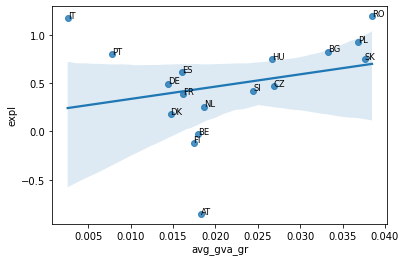

In [76]:
results = pd.DataFrame(results)
seaborn.regplot(x="avg_gva_gr", y="expl", data=results)
for line in range(0,results.shape[0]):
     plt.text(results.avg_gva_gr[line], results.expl[line], results.country[line], size='small', color='black')

In [56]:
results.corr()

,avg_gva_gr,avg_tfp_gr,expl
avg_gva_gr,1.000000,0.796792,0.261689
avg_tfp_gr,0.796792,1.000000,0.769946
expl,0.261689,0.769946,1.000000


In [96]:
data_7_es = eurostat.get_data_df('prc_hicp_aind')

In [128]:
data_7 = data_7_es
# data_7 = data_7[data_7["na_item"] == "D1_SAL_HW"]
data_7 = data_7[data_7["unit"] == "INX_A_AVG"]
data_7 = data_7[data_7["coicop"] == "AP"]
data_7 = pd.melt(data_7, id_vars=["geo\\time"], value_vars=list(range(1996, END_YEAR + 1)),
                     value_name="value", var_name="year")
data_7 = data_7.rename({"value": "hcpi"}, axis=1)
data_7 = data_7.dropna()
data_7

,geo\time,year,hcpi
234,AT,2002,73.64
235,BE,2002,80.83
236,BG,2002,52.86
238,CY,2002,78.57
239,CZ,2002,56.00
...,...,...,...
931,RS,2019,106.30
932,SE,2019,106.47
933,SI,2019,112.68
934,SK,2019,101.80


In [219]:
data_final_2 = data_1_ln
data_final_2 = data_final_2[data_final_2["geo\\time"] == BASE_LOCATION]
data_final_2 = data_final_2.merge(data_6, on=["geo\\time", "year"])
data_final_2 = data_final_2.merge(data_5_ln, on=["geo\\time", "year"])
data_final_2 = data_final_2.merge(data_3_gmean, on=["geo\\time", "year"])
data_final_2["total_compensations_eur"] = (data_final_2["thousands_hours_worked"] * data_final_2["compensation_per_hour_eur"])
data_final_2["total_compensations_eur"] = data_final_2["total_compensations_eur"] / 10 ** 3
data_final_2["1 - alpha"] = data_final_2["total_compensations_eur"] / data_final_2["gross_value_added_eur"]
data_final_2["1 - alpha t-1"] = data_final_2["1 - alpha"].shift()
data_final_2["alpha"] = 1 - data_final_2["1 - alpha"]
data_final_2["alpha t-1"] = data_final_2["alpha"].shift()

data_final_2["total_compensations_eur_2010"] = data_final_2["total_compensations_eur"] / (data_final_2["implicit_deflator_2010_eur"] / 100)
data_final_2["total_compensations_t-1_eur_2010"] = data_final_2["total_compensations_eur_2010"].shift()
data_final_2["total_compensations_index_eur_2010"] = data_final_2["total_compensations_eur_2010"] / data_final_2["total_compensations_t-1_eur_2010"]

data_final_2["tfp_index"] = data_final_2["gross_value_added_index_eur_2010"] / (numpy.power(data_final_2["total_fixed_assets_index_eur_2010"], numpy.power(data_final_2["alpha t-1"] + data_final_2["alpha"], 1/2)) * numpy.power(data_final_2["total_compensations_index_eur_2010"], numpy.power(data_final_2["1 - alpha t-1"] + data_final_2["1 - alpha"], 1/2)))
data_final_2["tfp_index"] = numpy.power(data_final_2["total_fixed_assets_index"], numpy.power(data_final_2["alpha t-1"] + data_final_2["alpha"], 1/2))
data_final_2[["year", "compensation_per_hour_eur", "total_compensations_eur", "gross_value_added_eur", "1 - alpha", "gross_value_added_index", "total_fixed_assets_index_eur_2010", "total_compensations_index_eur_2010", "tfp_index"]]

,year,compensation_per_hour_eur,total_compensations_eur,gross_value_added_eur,1 - alpha,gross_value_added_index,total_fixed_assets_index_eur_2010,total_compensations_index_eur_2010,tfp_index
0,1997,20.5,7.838472e+05,1144789.1,0.684709,1.033291,1.022958,NaN,NaN
1,1998,21.0,8.117032e+05,1199515.6,0.676692,1.046032,1.026758,1.024825,1.021330
2,1999,21.5,8.472528e+05,1251478.0,0.677002,1.036707,1.030476,1.034994,1.024431
3,2000,22.4,8.936836e+05,1326341.0,0.673796,1.059820,1.021824,1.033892,1.017547
4,2001,23.2,9.266250e+05,1384016.0,0.669519,1.043484,1.030057,1.013375,1.024288
5,2002,24.6,9.655115e+05,1430220.0,0.675079,1.033384,1.030217,1.019539,1.024393
6,2003,25.2,9.915428e+05,1469233.0,0.674871,1.027278,1.041033,1.006818,1.032954
7,2004,25.7,1.028465e+06,1532690.0,0.671020,1.043191,1.030562,1.024430,1.024647
8,2005,26.4,1.064600e+06,1586085.0,0.671213,1.034837,1.033832,1.015111,1.027352
9,2006,27.5,1.108522e+06,1654464.0,0.670019,1.043112,1.024411,1.022954,1.019768


In [221]:
data_final_2[["year", "1 - alpha", "gross_value_added_index", "total_fixed_assets_index_eur_2010", "total_compensations_index_eur_2010", "tfp_index"]]

,year,1 - alpha,gross_value_added_index,total_fixed_assets_index_eur_2010,total_compensations_index_eur_2010,tfp_index
0,1997,0.684709,1.033291,1.022958,NaN,NaN
1,1998,0.676692,1.046032,1.026758,1.024825,1.021330
2,1999,0.677002,1.036707,1.030476,1.034994,1.024431
3,2000,0.673796,1.059820,1.021824,1.033892,1.017547
4,2001,0.669519,1.043484,1.030057,1.013375,1.024288
5,2002,0.675079,1.033384,1.030217,1.019539,1.024393
6,2003,0.674871,1.027278,1.041033,1.006818,1.032954
7,2004,0.671020,1.043191,1.030562,1.024430,1.024647
8,2005,0.671213,1.034837,1.033832,1.015111,1.027352
9,2006,0.670019,1.043112,1.024411,1.022954,1.019768


In [212]:
data_final_2_group_by = data_final_2.dropna(subset=["tfp_index"], axis=0).agg({"tfp_index": [gmean]}) - 1
data_final_2_group_by

,tfp_index
gmean,0.016102


In [213]:
data_final_2_group_by = data_final_2.dropna(subset=["gross_value_added_index_eur_2010"], axis=0).agg({"gross_value_added_index_eur_2010": [gmean]}) - 1
data_final_2_group_by


,gross_value_added_index_eur_2010
gmean,0.012904


In [231]:
results = []
for current_country in LOCATIONS:
  data_final_2 = data_1_ln
#   data_final_2 = data_1_ln.merge(data_7, on=["year", "geo\\time"])
  data_final_2 = data_final_2[data_final_2["geo\\time"] == current_country]
  data_final_2 = data_final_2.merge(data_6, on=["geo\\time", "year"])
  data_final_2 = data_final_2.merge(data_5_ln, on=["geo\\time", "year"])
  data_final_2 = data_final_2.merge(data_3_gmean, on=["geo\\time", "year"])
  data_final_2["total_compensations_eur"] = (data_final_2["thousands_hours_worked"] * data_final_2["compensation_per_hour_eur"])
  data_final_2["total_compensations_eur"] = data_final_2["total_compensations_eur"] / 10 ** 3
  data_final_2["1 - alpha"] = data_final_2["total_compensations_eur"] / data_final_2["gross_value_added_eur"]
  data_final_2["1 - alpha t-1"] = data_final_2["1 - alpha"].shift()
  data_final_2["alpha"] = 1 - data_final_2["1 - alpha"]
  data_final_2["alpha t-1"] = data_final_2["alpha"].shift()

  data_final_2["total_compensations_eur_2010"] = data_final_2["total_compensations_eur"] / (data_final_2["implicit_deflator_2010_eur"] / 100)
  data_final_2["total_compensations_t-1_eur_2010"] = data_final_2["total_compensations_eur_2010"].shift()
  data_final_2["total_compensations_index_eur_2010"] = data_final_2["total_compensations_eur_2010"] / data_final_2["total_compensations_t-1_eur_2010"]

  data_final_2["tfp_index"] = data_final_2["gross_value_added_index_eur_2010"] / (numpy.power(data_final_2["total_fixed_assets_index_eur_2010"], numpy.power(data_final_2["alpha t-1"] + data_final_2["alpha"], 1/2)) * numpy.power(data_final_2["total_compensations_index_eur_2010"], numpy.power(data_final_2["1 - alpha t-1"] + data_final_2["1 - alpha"], 1/2)))
  data_final_2["tfp_index"] = numpy.power(data_final_2["total_fixed_assets_index"], numpy.power(data_final_2["alpha t-1"] + data_final_2["alpha"], 1/2))

  avg_tfp_gr = data_final_2.dropna(subset=["tfp_index"], axis=0).agg({"tfp_index": [gmean]}) - 1
  avg_gva_gr = data_final_2.dropna(subset=["gross_value_added_index_eur_2010"], axis=0).agg({"gross_value_added_index_eur_2010": [gmean]}) - 1
  if avg_tfp_gr.shape[0] == 1 and avg_gva_gr.shape[0] == 1:
    results.append({"country": current_country, "avg_gva_gr": avg_gva_gr.iloc[0,0], "avg_tfp_gr": avg_tfp_gr.iloc[0,0]})
results = pd.DataFrame(results)
results["expl"] = results["avg_tfp_gr"] / results["avg_gva_gr"]
results

,country,avg_gva_gr,avg_tfp_gr,expl
0,AT,0.018698,0.018319,0.979730
1,BE,0.018970,0.014290,0.753326
2,BG,0.034159,0.023309,0.682357
3,CZ,0.025873,0.024709,0.954988
4,DE,0.014991,0.013218,0.881697
5,DK,0.015693,0.015926,1.014864
6,ES,0.016497,0.018457,1.118800
7,FI,0.019971,0.016668,0.834616
8,FR,0.016718,0.017528,1.048449
9,HU,0.027601,0.021492,0.778667


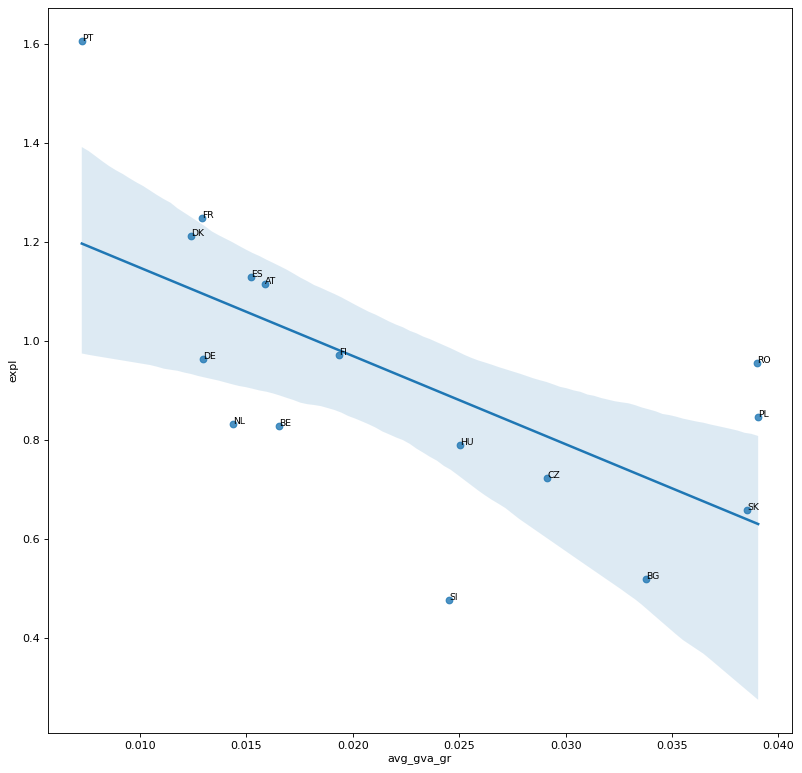

In [227]:
from matplotlib.pyplot import figure

figure(figsize=(12, 12), dpi=80)
results2 = pd.DataFrame(results)
results2 = results2[~results2["country"].isin(["IT"])]
results2 = results2.reset_index()
seaborn.regplot(x="avg_gva_gr", y="expl", data=results2)
for line in range(0,results2.shape[0]):
     plt.text(results2.avg_gva_gr[line], results2.expl[line], results2.country[line], size='small', color='black')

